# Air Quality Forecasting

## 1. 1. Setup and Imports


In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')

from src.data_utils import *
from src.model_utils import *

sns.set_style('whitegrid')

## 2. Data Preparation Pipeline


In [2]:
# Load and clean the raw data
df = load_data('../data/train.csv')
df = handle_missing_values(df)

# Create time-based features
df = create_time_features(df)

# Split into training and validation sets
df_train, df_val = split_data(df)

# Define features to scale and apply the StandardScaler
features_to_scale = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'day_of_week', 'month']
df_train_scaled, df_val_scaled, scaler = scale_features(
    train_df=df_train.copy(), 
    val_df=df_val.copy(), 
    columns_to_scale=features_to_scale,
    scaler_type='standard' # <-- The key change for this experiment
)

✅ Data loaded successfully.
✅ Missing values handled.
✅ Time-based features created.
✅ Data split into training and validation sets.
✅ Features scaled using StandardScaler.


/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.66087503 -1.51641739 -1.37195975 ... -0.64967155 -0.50521392
 -0.36075628]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train_df.loc[:, columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

## 3. Create Model Sequences
We transform the processed dataframes into the sequence format required by the LSTM model.

In [3]:
N_PAST = 24
TARGET_COL = 'pm2.5'
target_col_idx = df_train_scaled.columns.get_loc(TARGET_COL)

X_train, y_train = create_sequences(df_train_scaled.values, N_PAST, target_col_idx)
X_val, y_val = create_sequences(df_val_scaled.values, N_PAST, target_col_idx)

print(f"\n✅ Sequences created: X_train shape is {X_train.shape}")


✅ Sequences created: X_train shape is (26050, 24, 13)


## 4. Build and Train Model


In [4]:
EXP_ID = '02'
MODEL_TYPE = 'LSTM'
SCALER_TYPE = 'StandardScaler'
BATCH_SIZE = 32
MODEL_PATH = f'../experiments/models/{EXP_ID}_{SCALER_TYPE.lower()}_{MODEL_TYPE.lower()}.keras'

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape, model_type=MODEL_TYPE, units=32)
model.summary()

history = train_model(model, X_train, y_train, X_val, y_val, MODEL_PATH, batch_size=BATCH_SIZE)

/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921 (23.13 KB)

 Trainable params: 5,921 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
802/815 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3314
Epoch 1: val_loss improved from None to 0.10597, saving model to ../experiments/models/02_standardscaler_lstm.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1720 - val_loss: 0.1060
Epoch 2/50
792/815 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0677
Epoch 2: val_loss improved from 0.10597 to 0.10572, saving model to ../experiments/models/02_standardscaler_lstm.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0721 - val_loss: 0.1057
Epoch 3/50
793/815 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0689
Epoch 3: val_loss improved from 0.10572 to 0.10151, saving model to ../experiments/models/02_standardscaler_lstm.keras
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0685 - val_loss: 0.1015
Epoch 4/50
799/815 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0664
Epoch 4: val_loss did not improve from 0.10151
815/815 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0671 - val_loss: 0.1020
Epoch 5/50
805/815 ━━━━━━━━━━━━

## 5. Evaluate Model Performance


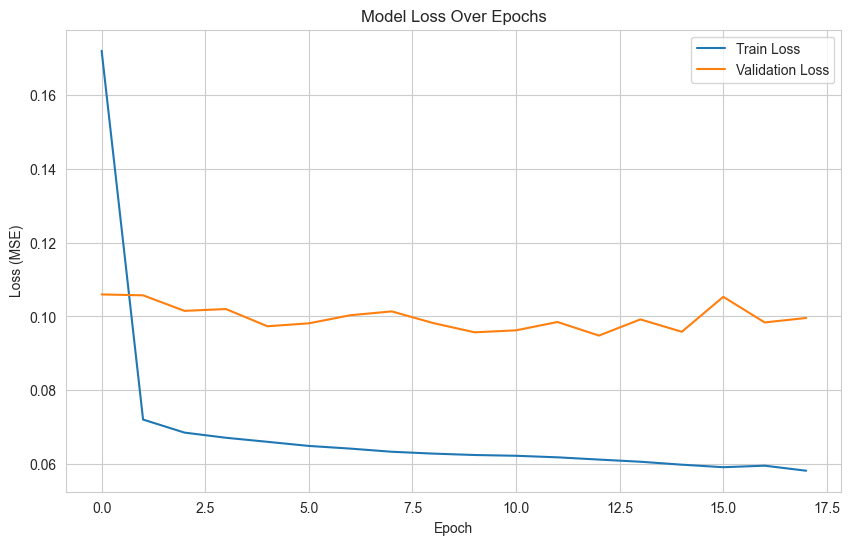

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
--- Model Evaluation ---
✅ Final Validation RMSE: 0.31


In [5]:
# Evaluate the final model by plotting its history and calculating RMSE
final_rmse = evaluate_model(history, model, X_val, y_val)

## 6. Log Experiment and Generate Submission


In [6]:
LOG_PATH = f'../experiments/metrics/{EXP_ID}_{SCALER_TYPE.lower()}_{MODEL_TYPE.lower()}_log.txt'
SUBMISSION_FILENAME = f'../submissions/{EXP_ID}_{SCALER_TYPE.lower()}_{MODEL_TYPE.lower()}_submission.csv'

# Log all experiment details to a file
log_experiment(
    model=model, history=history, rmse=final_rmse, log_path=LOG_PATH,
    exp_id=EXP_ID, model_type=f'{MODEL_TYPE} ({SCALER_TYPE})', sequence_length=N_PAST,
    batch_size=BATCH_SIZE, scaler_type=SCALER_TYPE, optimizer='adam',
    notes="Second experiment, switching from RobustScaler to StandardScaler."
)

# Generate the Kaggle submission file
submission_df = generate_submission(
    model_path=MODEL_PATH,
    train_scaled=df_train_scaled,
    scaler=scaler,
    columns_to_scale=features_to_scale,
    N_PAST=N_PAST,
    TARGET_COL=TARGET_COL,
    submission_filename=SUBMISSION_FILENAME
)

print("\n--- Submission File Head ---")
display(submission_df.head())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,765 (69.40 KB)

 Trainable params: 5,921 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,844 (46.27 KB)

✅ Comprehensive experiment details logged to: ../experiments/metrics/02_standardscaler_lstm_log.txt
✅ Data loaded successfully.
✅ Missing values handled.
✅ Time-based features created.
✅ Features scaled using StandardScaler.
 90/411 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step

/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.10005871 -1.10005871 -1.10005871 ... -1.10005871 -1.10005871
 -1.10005871]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, columns_to_scale] = scaler.transform(train_df[columns_to_scale])
/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
Saved 13148 rows to ../submissions/../submissions/02_standardscaler_lstm_submission.csv

--- Submission File Head ---


,row ID,pm2.5
0,2013-07-02 4:00:00,22.252257
1,2013-07-02 5:00:00,52.628262
2,2013-07-02 6:00:00,20.475225
3,2013-07-02 7:00:00,17.111936
4,2013-07-02 8:00:00,10.376492
